# Лабораторная работа №1: Градиентный спуск

1. **Реализовать следующие численные методы оптимизации:**
* Классический градиентный спуск
* Инертный градинтный спуск
* Адаптивный градиентный спуск
2. **Протестировать работу релизованных методов на примере двух тестовых функций:**
* Функция Сферы
* Функция Мак Кормика
3. **Визуализировать полученные результаты**

# Подключение зависимостей

In [166]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as la

# Тестовые функции

In [167]:
class TestFunction:
    def __init__(self, name: str, domain: np.ndarray, glob_min: np.ndarray, fun: callable) -> None:
        
        """_summary_

        Args:
            domain (np.ndarray): Область определения функции
            glob_min (np.ndarray): Глобальный минимум
            fun (callable): Функция
        """
        self.name = name
        self.domain = domain
        self.glob_min = glob_min
        self.fun = fun

## Функция Сферы
* Функция: $f(\boldsymbol{x}) = \sum_{i=1}^{n} x_{i}^{2}$
* Область определения: $ -\infty \le x_{i} \le \infty$
* Глобальный минимум: $f(x_{1}, \dots, x_{n}) = f(0, \dots, 0) = 0$

In [168]:
Sphere = TestFunction(
    name = "Sphere",
    fun = lambda p: p[0]*p[0] + p[1]*p[1],
    domain = np.array([[-3., -3.], [3., 3.]]),
    glob_min = np.array([0., 0., 0.]))

## Функция Мак Кормика
* Функция: $f(x,y) = \sin \left(x+y\right) + \left(x-y\right)^{2} - 1.5x + 2.5y + 1$
* Область определения: $-1.5\le x \le 4 \:and\: -3\le y \le 4$
* Глобальный минимум: $f(-0.54719,-1.54719) = -1.9133$

In [169]:
McCormick = TestFunction(
    name = "McCormick",
    fun = lambda p: np.sin(p[0] + p[1]) + (p[0] - p[1]) ** 2 - 1.5 * p[0] + 2.5 * p[1] + 1,
    domain = np.array([[-1.5, -3.], [5., 4.]]),
    glob_min = np.array([-0.54719, -1.54719, -1.9133]))

# Графика: визуализация полученных результатов

In [170]:
def draw_result(fun: callable, domain: np.array, glob_min: np.array, path: np.array, title: str) -> None:

    """Визуализация градиентного спуска

    Args:
        fun (callable): Функция искуственного ландшавта
        domain (np.array): Область определения функции
        glob_min (np.array): Глобальный минимум функции
        path (np.array): История градиентного спуска
        title (str): Содержание заголовка
    """

    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection = '3d')
    
    x = np.linspace(domain[0, 0], domain[1, 0], 100)
    y = np.linspace(domain[0, 1], domain[1, 1], 100)
    
    x_grid, y_grid = np.meshgrid(x, y)
    z_grid = fun(np.array([x_grid, y_grid]))
    
    ax.plot_surface(x_grid, y_grid, z_grid, cmap = 'plasma', alpha=0.5)    
    ax.plot(path[:, 0], path[:, 1], path[:, 2], '-o', c='black', label = 'Градиентный спуск', alpha = 0.7)
    ax.scatter3D(path[0, 0], path[0, 1], path[0, 2], s=100, c="white", lw=2, ec='black', marker = 'D', label="Начальная точка")
    ax.scatter3D(path[-1, 0], path[-1, 1], path[-1, 2], s=190, c="white", lw=2, ec='black', marker = 'X', label="Найденный минимум")
    ax.scatter3D(glob_min[0], glob_min[1], glob_min[2], s=150, c="red", lw=2, ec='black', marker = 'o', label="Глобальный минимум", alpha = 0.7)

    np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
    print(f"Начальная точка:\t{path[0]}")
    np.set_printoptions(formatter={'float_kind':"{:.2e}".format})
    print(f"Найденный минимум:\t{path[-1]}")
    print(f"Глобальный минимум:\t{glob_min}")
    print(f"Кол-во итераций:\t{len(path)}")
    fig.text(0.9, 0.1, s=f"Кол-во итераций: {len(path)}", horizontalalignment="right", fontsize = 12)

    ax.set_title(title, fontsize = 12, fontweight="bold",loc="left")
    ax.legend(loc="upper left")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# Вспомогательные функции

In [171]:
def grad(fun: callable, point: np.ndarray, dt: float = 0.00001) -> np.array:
    
    """Вычисляет градиент функции в точке

    Args:
        fun (callable): Функция искуственного ландшавта
        point (np.ndarray): Точка (массив параметров)
        dt (float, optional): Изменение аргумента. Defaults to 0.00001.

    Returns:
        np.array: _description_
    """

    dxdt = (fun(point + np.array([dt, 0])) - fun(point)) / dt
    dydt = (fun(point + np.array([0, dt])) - fun(point)) / dt
    return np.array([dxdt, dydt])

# Методы оптимизации

## Классический градиентный спуск

In [172]:
def classic_GD(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, 
    max_iter: int = 64, lr: float = 0.1, delta: float = 0.001
    ) -> np.array:

    """Классический градиентный спуск

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 64.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):

        # Вычисляем новое значение параметров
        params = params - lr * grad(fun, params)

        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return np.array(path)

Начальная точка:	[2.00 2.70 11.29]
Найденный минимум:	[5.14e-04 6.96e-04 7.49e-07]
Глобальный минимум:	[0.00e+00 0.00e+00 0.00e+00]
Кол-во итераций:	38


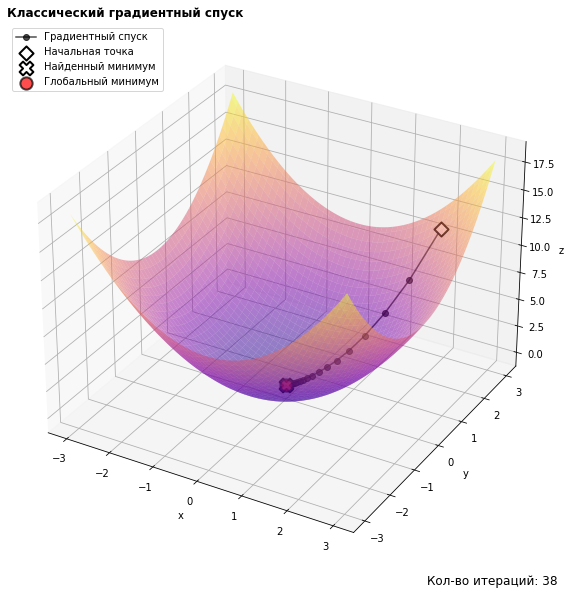

In [173]:
# Для Сферы
path = classic_GD(Sphere.fun, np.array([2.0, 2.7]), Sphere.glob_min)
draw_result(Sphere.fun, Sphere.domain, Sphere.glob_min, path, "Классический градиентный спуск")

Начальная точка:	[-1.00 3.00 26.91]
Найденный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Кол-во итераций:	57


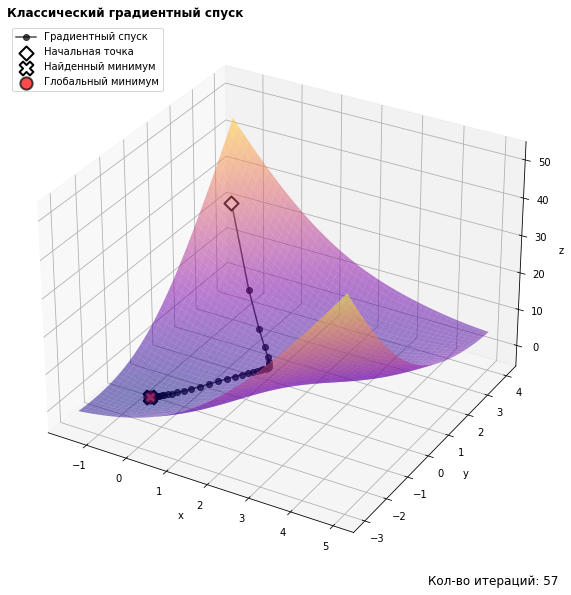

In [174]:
# Для Мак Кормика
path = classic_GD(McCormick.fun, np.array([-1.0, 3.0]), McCormick.glob_min)
draw_result(McCormick.fun, McCormick.domain, McCormick.glob_min, path, "Классический градиентный спуск")

## Инертный градиентный спуск

In [175]:
def inertial_GD(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, 
    max_iter: int = 64, lr: float = 0.1, delta: float = 0.001, beta: float = 0.5
    ) -> np.array:
    
    """Инертный градиентный спуск

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 64.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.
        beta (float, optional): Коэффициент энертности. Defaults to 0.5.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params_prev = start_params.copy()
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):

        # Вычисляем новое значение параметров
        params_new = params - lr * grad(fun, params) + beta * (params - params_prev)
        params_prev = params
        params = params_new
        
        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return np.array(path)

Начальная точка:	[2.00 2.70 11.29]
Найденный минимум:	[5.55e-04 7.51e-04 8.72e-07]
Глобальный минимум:	[0.00e+00 0.00e+00 0.00e+00]
Кол-во итераций:	21


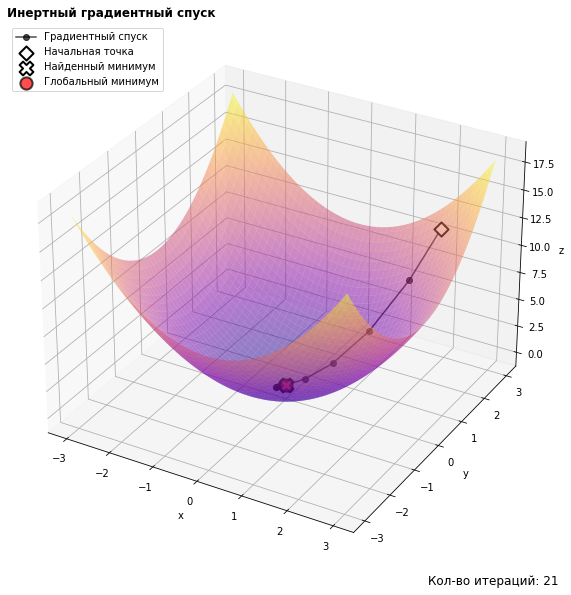

In [176]:
# Для Сферы
path = inertial_GD(Sphere.fun, np.array([2.0, 2.7]), Sphere.glob_min)
draw_result(Sphere.fun, Sphere.domain, Sphere.glob_min, path, "Инертный градиентный спуск")

Начальная точка:	[-1.00 3.00 26.91]
Найденный минимум:	[-5.46e-01 -1.55e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Кол-во итераций:	34


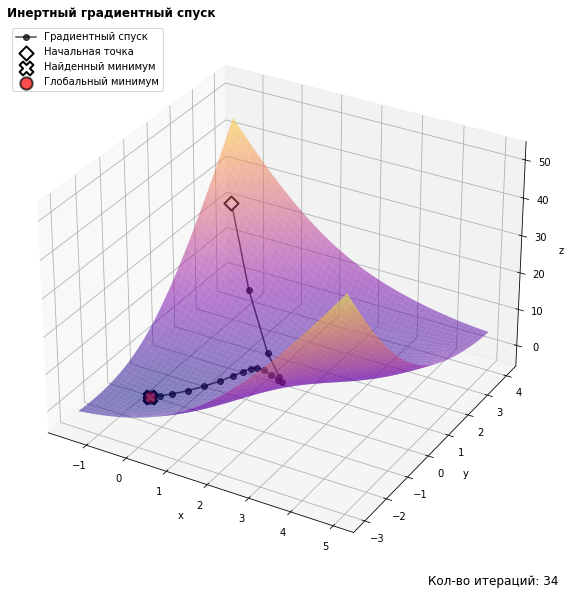

In [177]:
# Для Мак Кормика
path = inertial_GD(McCormick.fun, np.array([-1.0, 3.0]), McCormick.glob_min)
draw_result(McCormick.fun, McCormick.domain, McCormick.glob_min, path, "Инертный градиентный спуск")

## Адаптивный градиентный спуск: Adam

In [178]:
def Adam_GD(
    fun: callable, start_params: np.ndarray, glob_min: np.ndarray, max_iter: int = 256, 
    lr: float = 0.1, b1: float = 0.6, b2: float = 0.999, e: float = 10e-8, delta: float = 0.001
    ) -> np.array:
    
    """Адаптивный градиентный спуск: Adam

    Args:
        fun (callable): Функция искуственного ландшавта
        start_params (np.ndarray): Начальный набор параметров
        glob_min (np.ndarray): Глобальный минимум рассматриваемой функции
        max_iter (int, optional): Ограничение по кол-ву итераций. Defaults to 256.
        lr (float, optional): Шаг обучения. Defaults to 0.1.
        b1 (float, optional): Параметр beta1. Defaults to 0.6.
        b2 (float, optional): Параметр beta2. Defaults to 0.999.
        e (float, optional): "Бесконечно малое" число. Defaults to 10e-8.
        delta (float, optional): Радиус сходимости. Defaults to 0.001.

    Returns:
        np.array: История градиентного спуска
    """

    # Рассчитываем начальный набор параметров
    params = start_params.copy()
    path = [np.array([params[0], params[1], fun(params)])]

    # Инициализируем первый и второй моменты
    m = np.array([0, 0])
    v = np.array([0, 0])
    
    step = 0
    while (step < max_iter and la.norm(path[-1] - glob_min) > delta):
        
        # Считаем первый первый и второй моменты
        m = b1 * m + (1 - b1) * grad(fun, params)
        v = b2 * v + (1 - b2) * grad(fun, params) ** 2

        # Вычисляем новое значение параметров
        params = params - lr * m / (np.sqrt(v) + e)
        
        # Логируем результат
        path.append(np.array([params[0], params[1], fun(params)]))
        step += 1

    return np.array(path)

Начальная точка:	[2.00 2.70 11.29]
Найденный минимум:	[6.28e-04 3.56e-04 5.21e-07]
Глобальный минимум:	[0.00e+00 0.00e+00 0.00e+00]
Кол-во итераций:	31


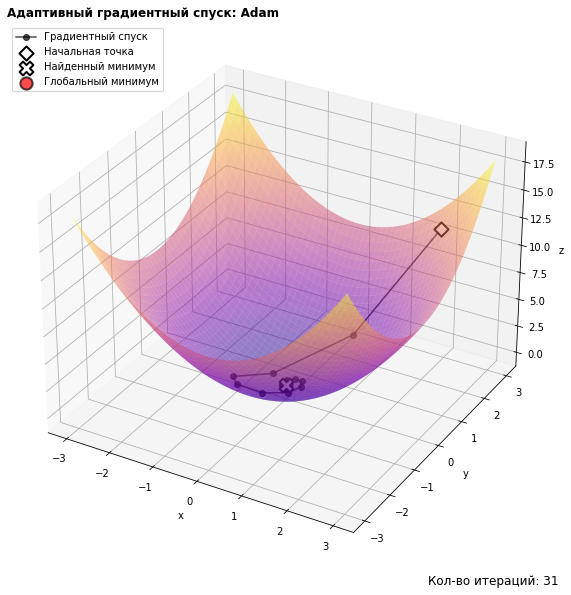

In [179]:
# Для Сферы
path = Adam_GD(Sphere.fun, np.array([2.0, 2.7]), Sphere.glob_min)
draw_result(Sphere.fun, Sphere.domain, Sphere.glob_min, path, "Адаптивный градиентный спуск: Adam")

Начальная точка:	[-1.00 3.00 26.91]
Найденный минимум:	[-5.48e-01 -1.55e+00 -1.91e+00]
Глобальный минимум:	[-5.47e-01 -1.55e+00 -1.91e+00]
Кол-во итераций:	40


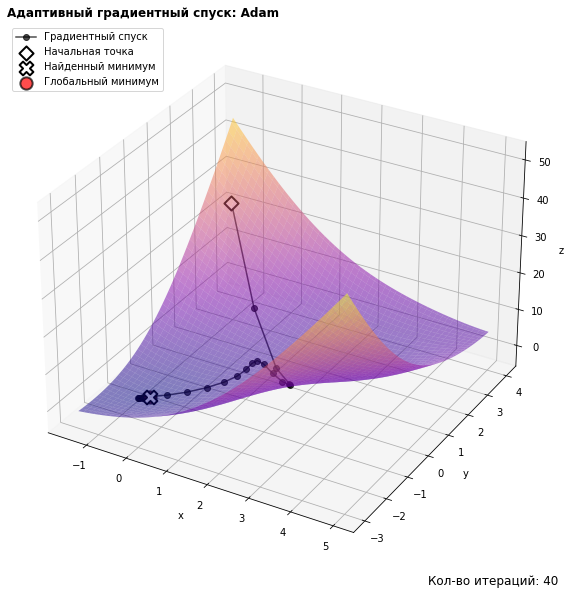

In [180]:
# Для Мак Кормика
path = Adam_GD(McCormick.fun, np.array([-1.0, 3.0]), McCormick.glob_min)
draw_result(McCormick.fun, McCormick.domain, McCormick.glob_min, path, "Адаптивный градиентный спуск: Adam")

# Дополнительно

### Анализ сходимости Adam'a
В рамках задачи по оптимизации параметров функций ПРОСТЫХ ландшавтов Adam сильно уступает классическому и инертному методу в времени выполнения.
Однако варьирование параметра beta1 в меньшую сторону сильно способствует скорости сходимости алгоритма.

Text(0, 0.5, 'Кол-во итераций')

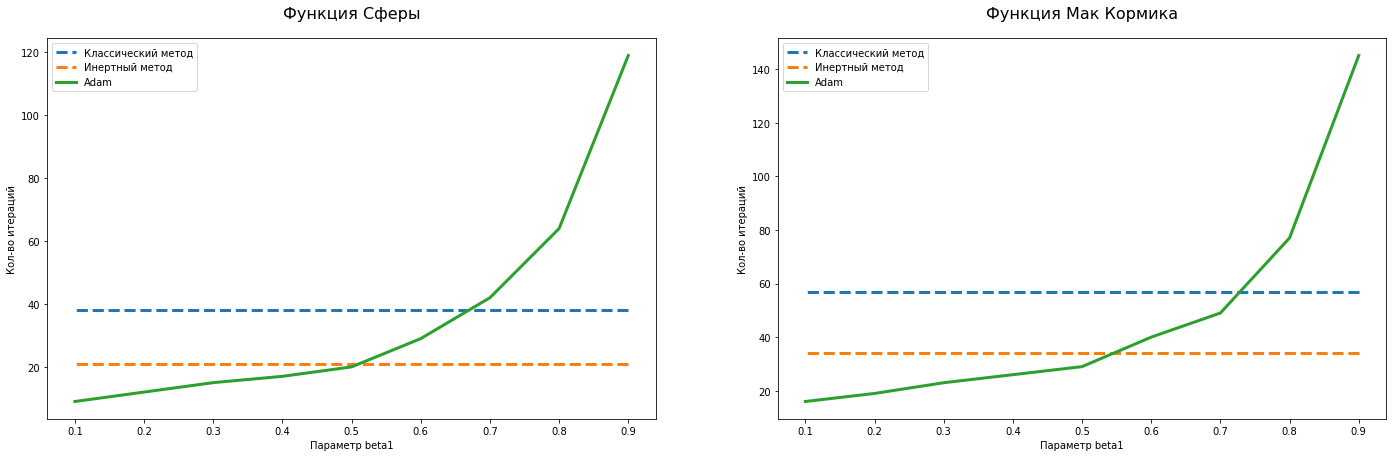

In [181]:
McCormick_path_lens =[] 
Sphere_path_lens =[] 
beta1_list = np.linspace(0.9, 0.1, 9)

# Вычисляем кол-во итераций для каждого beta1 
for beta1 in beta1_list:
    McCormick_path = Adam_GD(McCormick.fun, np.array([-1.0, 3.0]), McCormick.glob_min, b1=beta1)
    McCormick_path_lens.append(len(McCormick_path))  
    Sphere_path = Adam_GD(Sphere.fun, np.array([-1.0, 3.0]), Sphere.glob_min, b1=beta1)
    Sphere_path_lens.append(len(Sphere_path)) 

fig = plt.figure(figsize = (24, 7))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Результаты классического метода
path = classic_GD(Sphere.fun, np.array([2.0, 2.7]), Sphere.glob_min)
ax1.plot(beta1_list, np.full(9, len(path)), '--', label = "Классический метод", lw = 3)

path = classic_GD(McCormick.fun, np.array([-1.0, 3.0]), McCormick.glob_min)
ax2.plot(beta1_list, np.full(9, len(path)), '--', label = "Классический метод", lw = 3)

# Результаты инертного метода
path = inertial_GD(Sphere.fun, np.array([2.0, 2.7]), Sphere.glob_min)
ax1.plot(beta1_list, np.full(9, len(path)), '--', label = "Инертный метод", lw = 3)

path = inertial_GD(McCormick.fun, np.array([-1.0, 3.0]), McCormick.glob_min)
ax2.plot(beta1_list, np.full(9, len(path)), '--', label = "Инертный метод", lw = 3)

# Результаты адаптивного метода: Adam
ax1.plot(beta1_list, Sphere_path_lens, label = "Adam", lw = 3)
ax2.plot(beta1_list, McCormick_path_lens, label = "Adam", lw = 3)

ax1.set_title("Функция Сферы", pad=20, fontsize = 16, loc="center")
ax2.set_title("Функция Мак Кормика", pad=20, fontsize = 16, loc="center")
ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
ax1.set_xlabel('Параметр beta1')
ax2.set_xlabel('Параметр beta1')
ax1.set_ylabel('Кол-во итераций')
ax2.set_ylabel('Кол-во итераций')